# Adaline

**Adaline (ADAptive LInear NEuron)** is another type of single layer neural network. Instead of a **unit step function** we will have a **linear activation** function that will spit continuous values instead of class labels.

## Batch Gradient Descent

One of the key ways to *learn* is to define an objective function to be optimized during learning. For instance, we can define a cost function $J$ to learn the weights as the **Sum of Squared Errors (SSE)** between the calculated outcomes and the true class labels:

$$
J(w) = \frac{1}{2} \sum_{i}(y^{(i)}-\phi(z^{(i)}))^2
$$

The $\frac{1}{2}$ term is added only for convenience, it will make it easier to derive the gradient.

We can find the minimum by subsequent steps away from the gradient $\nabla J(w)$ in this way: 

$$
w:=w + \Delta w
$$

The weight change $\Delta w$ is defined as the negative gradient multiplied by the learning rate $\eta$:

$$
\Delta w=-\eta \nabla J(w)
$$

To compute the gradient of the cost function we calculate the partial derivative of the cost function:

$$
\frac{\delta J}{\delta w_j}=-\sum_{i}(y^{(i)}-\phi (z^{(i)}))x_{j}^{(i)}
$$

In this way we can write the update of the weight $w_j$ as $\Delta w_j=-\eta \sum_{i}(y^{(i)}-\phi (z^{(i)}))x_{j}^{(i)}$, since we update our **Adaline** weights simultaneously we get:

$$
w:=w+\Delta w
$$

Since the weight update is calculated based on all samples in the training set we call it **batch gradient descent**

In [3]:
%matplotlib inline
import numpy as np

class AdalineGD(object):
    """Adaptive Linear Neuron Classifier.
    
    Parameters
    -----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training set
    random_state : int
        The seed for the random number generator
        
    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting
    cost_ : list
        Sum-of-squares cost function value in each epoch.
    
    """
    
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        """Fit training data.
        
        Parameters
        -----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors
        y : array-like, shape = [n_samples]
            Target values
        
        Returns
        --------
        self : object
        
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
                              size=1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """Compute linear activation"""
        return X
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

Instead of updating the weights after each training sample - as in the `Perceptron` - we calculate the gradient over the whole training set.

To find a good $\eta$ let's plot the result with $\eta = 0.1$ and $\eta = 0.0001$.

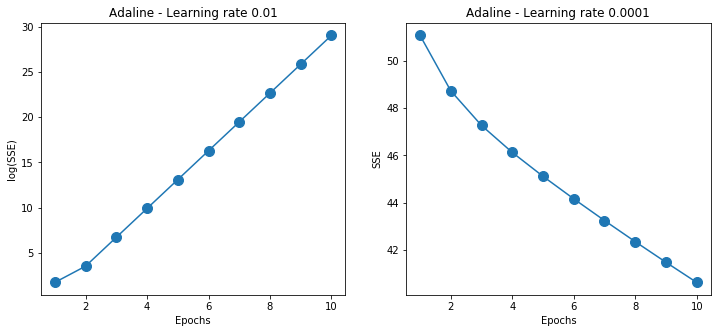

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header=None)
y = df.iloc[0:100, 4].values
y = np.where(y == "Iris-setosa", -1, 1)
X = df.iloc[0:100, [0, 2]].values

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))

ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker="o", markersize=10)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log(SSE)")
ax[0].set_title("Adaline - Learning rate 0.01")

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), ada2.cost_, marker="o", markersize=10)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("SSE")
ax[1].set_title("Adaline - Learning rate 0.0001")

plt.show()

As we can see in the left plot, the error gets worse with a large $\eta$ because we are overshooting the minimum, while it improves with a smaller learning rate, but it takes too long to converge.

Gradient descent benefits from **standardization**, so we standardize the features of our model before fitting. **Standardization** shifts the mean of each feature and centers it on 0 with a standard deviation of 1. To do it we can simply do 

$$x_{j}'=\frac{x_j-\mu_j}{\sigma_j}$$

Where $x_j$ is a vector of the $jth$ feature values, $\mu_j$ is the sample mean and $\sigma_j$ is the standard deviation.

In [5]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

Now rerun Adaline with $\eta = 0.01$

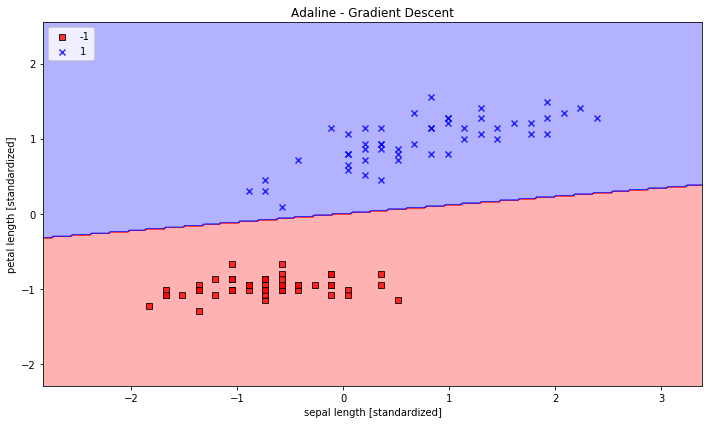

In [6]:
from algos.utils import plot_decision_regions

ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title("Adaline - Gradient Descent")
plt.xlabel("sepal length [standardized]")
plt.ylabel("petal length [standardized]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

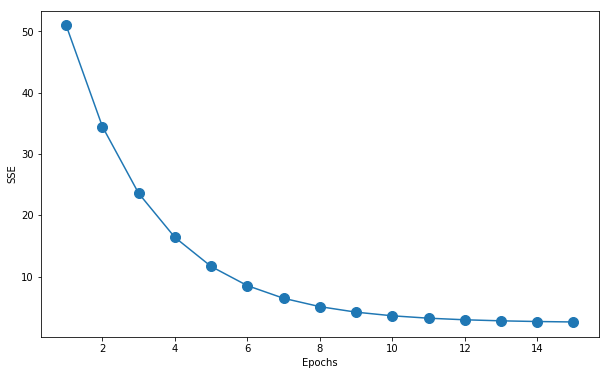

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker="o", markersize=10)
plt.xlabel("Epochs")
plt.ylabel("SSE")
plt.show()

## Stochastic Gradient Descent

Batch gradient descent re-evaluates every data point everytime it has to take a step. This can be computationally intensive for large datasets.

With **Stochastic gradient descent** we update the weights incrementally for each training sample:

$$
\eta (y^{(i)}-\phi (z^{(i)}))x^{i}
$$

Usually we replace $\eta$ with an **adaptive learning rate** that decreases over time:

$$
\frac{c_1}{[number\: of\: iterations]+c_2}
$$

Where $c_1$ and $c_2$ are constants.

One of the strenghts of **stochastic gradient descent** is that we can use it for **online learning**.

To avoid the creation of cycles it's important to shuffle data for every epoch

In [8]:
from numpy.random import seed

class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    cost_ : list
      Sum-of-squares cost function value averaged over all
      training samples in each epoch.

        
    """
    
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
            
    def fit(self, X, y):
        """Fit training data
        
        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
          Training vectors, where n_samples is the number of samples and
          n_features is the number of features.
        y : array-like, shape = [n_samples]
          Target values.

        Returns
        -------
        self : object
        
        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        """Fit training data by updating the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error ** 2
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        """Return class label"""
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

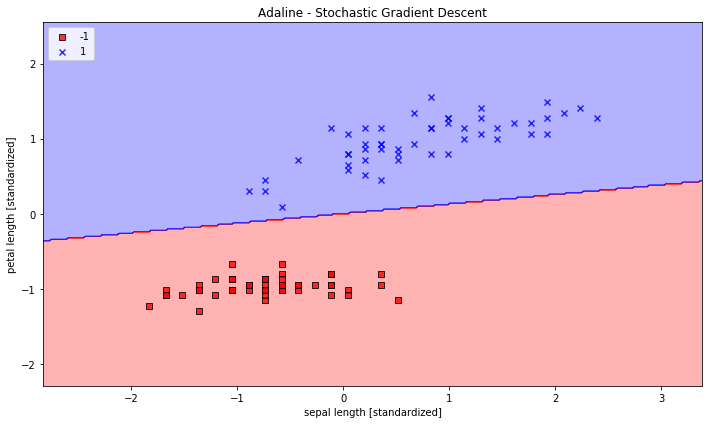

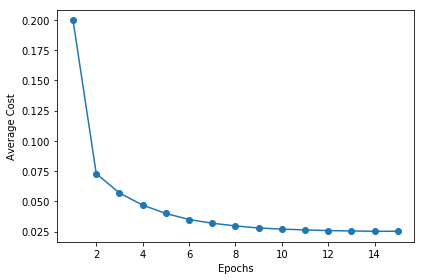

In [9]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')

plt.tight_layout()
plt.show()